In [ ]:
!pip install scipy scikit-image matplotlib pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom  # For a sample image
import pandas as pd
from scipy.interpolate import interp1d
import os

In [ ]:
#train data function
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
#test data function
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
!unzip -q /content/drive/MyDrive/BrainTumorData.zip -d /content/sample_data

In [ ]:
tr_df = train_df('/content/sample_data/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/sample_data/Training/notumor/Tr-no_12...,notumor
1,/content/sample_data/Training/notumor/Tr-no_12...,notumor
2,/content/sample_data/Training/notumor/Tr-no_06...,notumor
3,/content/sample_data/Training/notumor/Tr-no_00...,notumor
4,/content/sample_data/Training/notumor/Tr-no_10...,notumor
...,...,...
5707,/content/sample_data/Training/glioma/Tr-gl_062...,glioma
5708,/content/sample_data/Training/glioma/Tr-gl_117...,glioma
5709,/content/sample_data/Training/glioma/Tr-gl_043...,glioma
5710,/content/sample_data/Training/glioma/Tr-gl_079...,glioma


In [ ]:
ts_df = train_df('/content/sample_data/Testing')

In [ ]:
ts_df

,Class Path,Class
0,/content/sample_data/Testing/notumor/Te-no_008...,notumor
1,/content/sample_data/Testing/notumor/Te-no_017...,notumor
2,/content/sample_data/Testing/notumor/Te-no_028...,notumor
3,/content/sample_data/Testing/notumor/Te-no_019...,notumor
4,/content/sample_data/Testing/notumor/Te-no_011...,notumor
...,...,...
1306,/content/sample_data/Testing/glioma/Te-gl_0027...,glioma
1307,/content/sample_data/Testing/glioma/Te-gl_0025...,glioma
1308,/content/sample_data/Testing/glioma/Te-gl_0154...,glioma
1309,/content/sample_data/Testing/glioma/Te-gl_0119...,glioma


In [ ]:
tr_df.shape, ts_df.shape

((5712, 2), (1311, 2))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

ts_gen = _gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


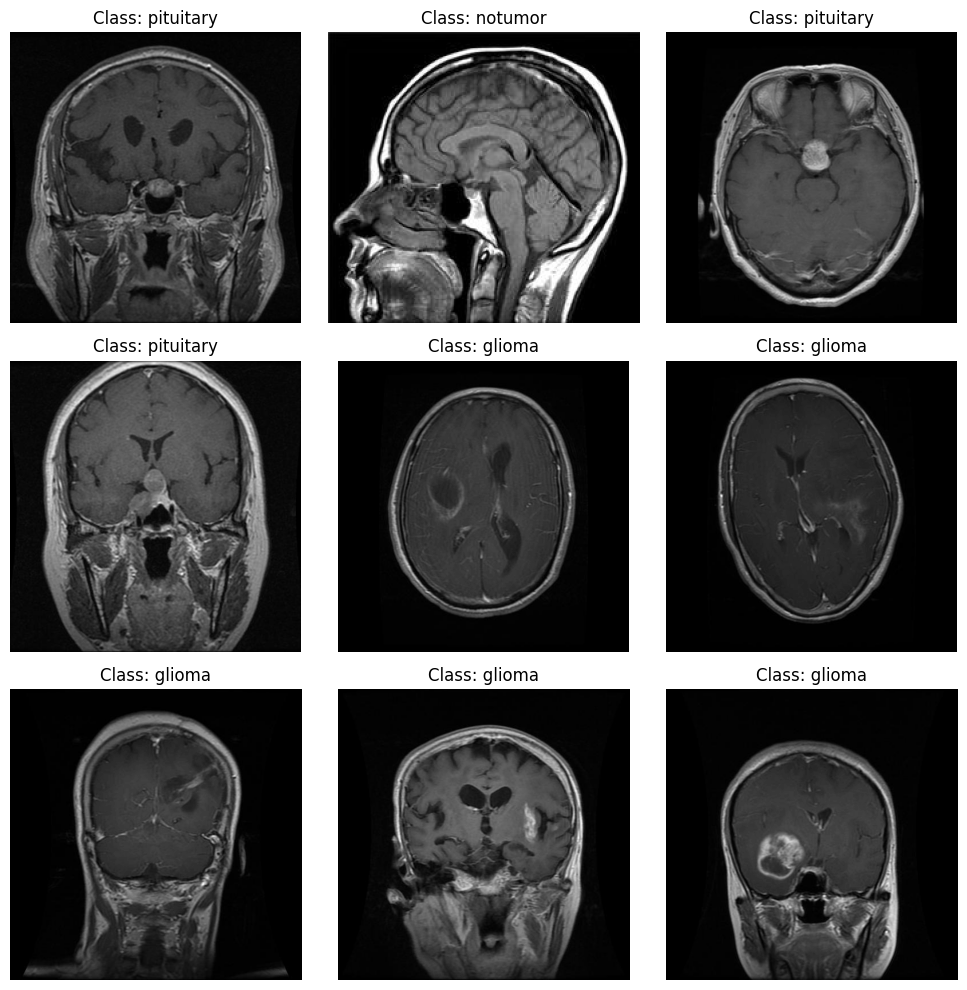

In [ ]:
from PIL import Image
# Function to display images from DataFrame
def show_sample_images(df, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        idx = np.random.randint(0, len(df))  # Randomly select an index
        row = df.iloc[idx]
        img = Image.open(row['Class Path']).convert('L')  # Convert to grayscale if necessary
        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {row['Class']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 9 sample images
show_sample_images(tr_df)

In [ ]:
#RCDT functions
def cdt(signal, reference=None):
    if reference is None:
        reference = np.linspace(0, 1, len(signal))
    cumsum_signal = np.cumsum(signal)
    cumsum_signal /= cumsum_signal[-1]  # Normalize to make it a CDF
    return interp1d(cumsum_signal, np.linspace(0, 1, len(signal)), fill_value="extrapolate")(reference)

def rcdt(image, angles):
    radon_image = radon(image, theta=angles, circle=True)
    rcdt_image = np.zeros_like(radon_image)

    for i in range(radon_image.shape[1]):
        projection = radon_image[:, i]
        projection = projection / np.sum(projection)
        rcdt_image[:, i] = cdt(projection)

    return rcdt_image

In [ ]:
import time
angles = np.linspace(0., 180., 299, endpoint=False)

skipped_images = []

def load_and_apply_rcdt(df, save_path, input_shape=(299, 299), batch_size=50):
    images, labels = [], []
    start_idx = 0

    if os.path.exists(save_path):
        data = np.load(save_path, allow_pickle=True)
        images, labels = list(data['images']), list(data['labels'])
        start_idx = len(images)

    for idx in range(start_idx, len(df)):
        row = df.iloc[idx]
        label = row['Class']
        image_path = row['Class Path']
        try:
            image = Image.open(image_path).convert('L')
            image = image.resize(input_shape[:2])
            image = np.array(image, dtype=np.float32) / 255.0
            rcdt_image = rcdt(image, angles)
            images.append(rcdt_image)
            labels.append(label)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            skipped_images.append((image_path, str(e)))

        if (idx + 1) % batch_size == 0 or (idx + 1) == len(df):
            np.savez(save_path, images=np.array(images), labels=np.array(labels))
            print(f"Progress saved at index {idx + 1}")

    # Report skipped images
    if skipped_images:
        print("Skipped images:")
        for image_path, error in skipped_images:
            print(f"{image_path}: {error}")
    labels = [str(label) for label in labels]  # Convert labels to strings
    labels = pd.get_dummies(labels).values
    return np.array(images), labels


In [ ]:
# Applying RCDT to train and test sets
X_train, y_train = load_and_apply_rcdt(tr_df, '/content/drive/MyDrive/X_train_rcdt.npz')
# Test data with RCDT
X_test, y_test = load_and_apply_rcdt(ts_df, '/content/drive/MyDrive/X_test_rcdt.npz')

In [ ]:
# Load training data
train_data = np.load('/content/drive/MyDrive/X_train_rcdt.npz', allow_pickle=True)
X_train, y_train = train_data['images'], pd.get_dummies(train_data['labels']).values



# Load test data
test_data = np.load('/content/drive/MyDrive/X_test_rcdt.npz', allow_pickle=True)
X_test, y_test = test_data['images'], pd.get_dummies(test_data['labels']).values


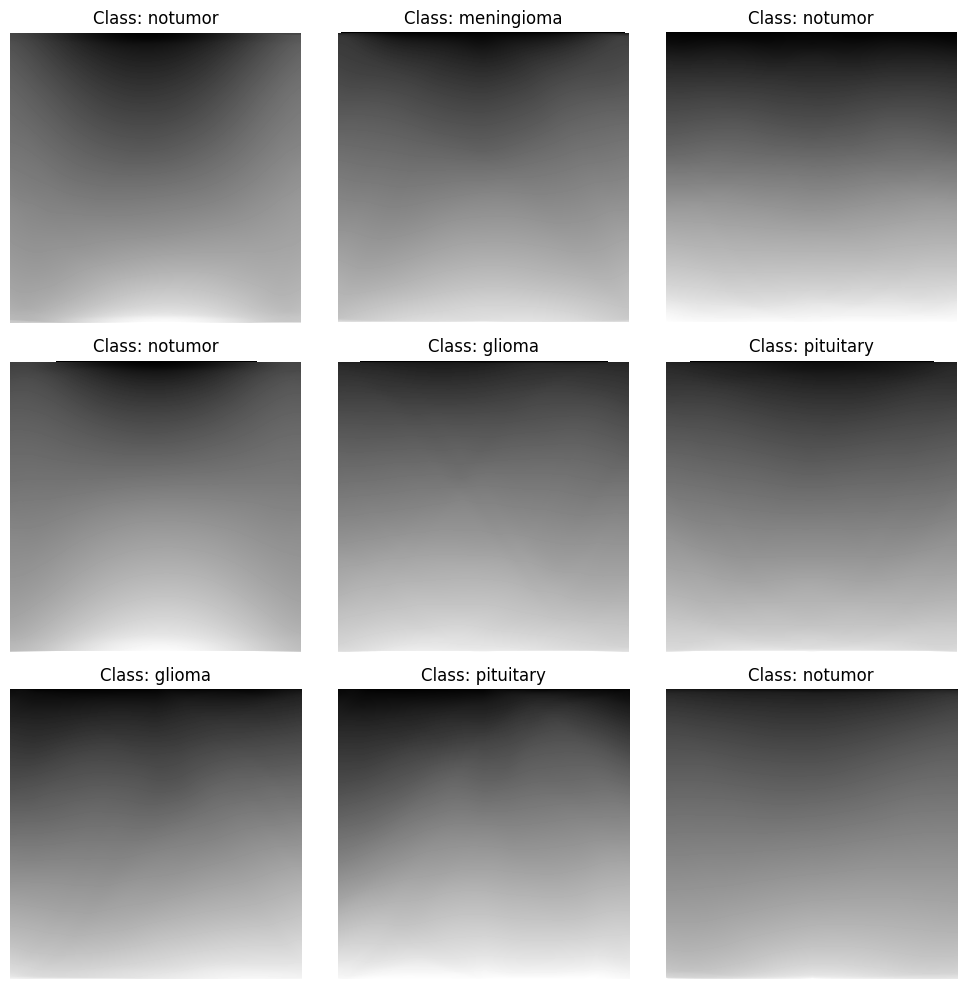

In [ ]:
import matplotlib.pyplot as plt
import random

def show_random_rcdt_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    indices = random.sample(range(len(images)), num_images)
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[idx], cmap='gray')  # Display the RCDT-transformed image

        # Safely get the class label
        label_index = np.argmax(labels[idx])
        if label_index < len(class_names):
            plt.title(f"Class: {class_names[label_index]}")
        else:
            plt.title("Unknown Class")

        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage example:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Adjust to your actual class names
show_random_rcdt_images(X_train, y_train, class_names)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from sklearn.model_selection import train_test_split

# Create a validation split from the training data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [ ]:
input_shape = (299, 299, 1)  # Adjust based on your RCDT image size

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Adjust based on the number of classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path = '/content/drive/MyDrive/rcdt_cnn_checkpoint.keras'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=False, verbose=1)


In [ ]:
batch_size = 32
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)


Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3782 - loss: nan
Epoch 1: val_loss did not improve from inf
161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.3782 - loss: nan - val_accuracy: 0.4143 - val_loss: nan
Epoch 2/10
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3949 - loss: nan
Epoch 2: val_loss did not improve from inf
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.3948 - loss: nan - val_accuracy: 0.4143 - val_loss: nan
Epoch 3/10
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3877 - loss: nan
Epoch 3: val_loss did not improve from inf
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.3877 - loss: nan - val_accuracy: 0.4143 - val_loss: nan
Epoch 4/10
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3877 - loss: nan
Epoch 4: val_loss did not improve from inf
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.3876 - loss: nan - val_accuracy: 0.4143 - val_loss: nan
Epoch 5/10
160/161 ━━━━━━━━━━━━━━━━━━━

In [ ]:
#Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.0361 - loss: nan
Test accuracy: 0.22883294522762299


In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert predictions to class indices
true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 299, 299), dtype=float32). Expected shape (None, 299, 299, 3), but input has incompatible shape (32, 299, 299)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 299, 299), dtype=float32)
  • training=False
  • mask=None

In [ ]:
import matplotlib.pyplot as plt
import random

def show_test_samples(X_test, predicted_classes, true_classes, class_names, num_samples=9):
    plt.figure(figsize=(10, 10))
    indices = random.sample(range(len(X_test)), num_samples)
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_test[idx], cmap='gray')
        plt.title(f"Pred: {class_names[predicted_classes[idx]]}\nTrue: {class_names[true_classes[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Adjust according to dataset classes
show_test_samples(X_test, predicted_classes, true_classes, class_names)


NameError: name 'predicted_classes' is not defined

In [ ]:
misclassified_indices = np.where(predicted_classes != true_classes)[0]
total_misclassified = len(misclassified_indices)
print("Total misclassified images:", total_misclassified)


Total misclassified images: 1011


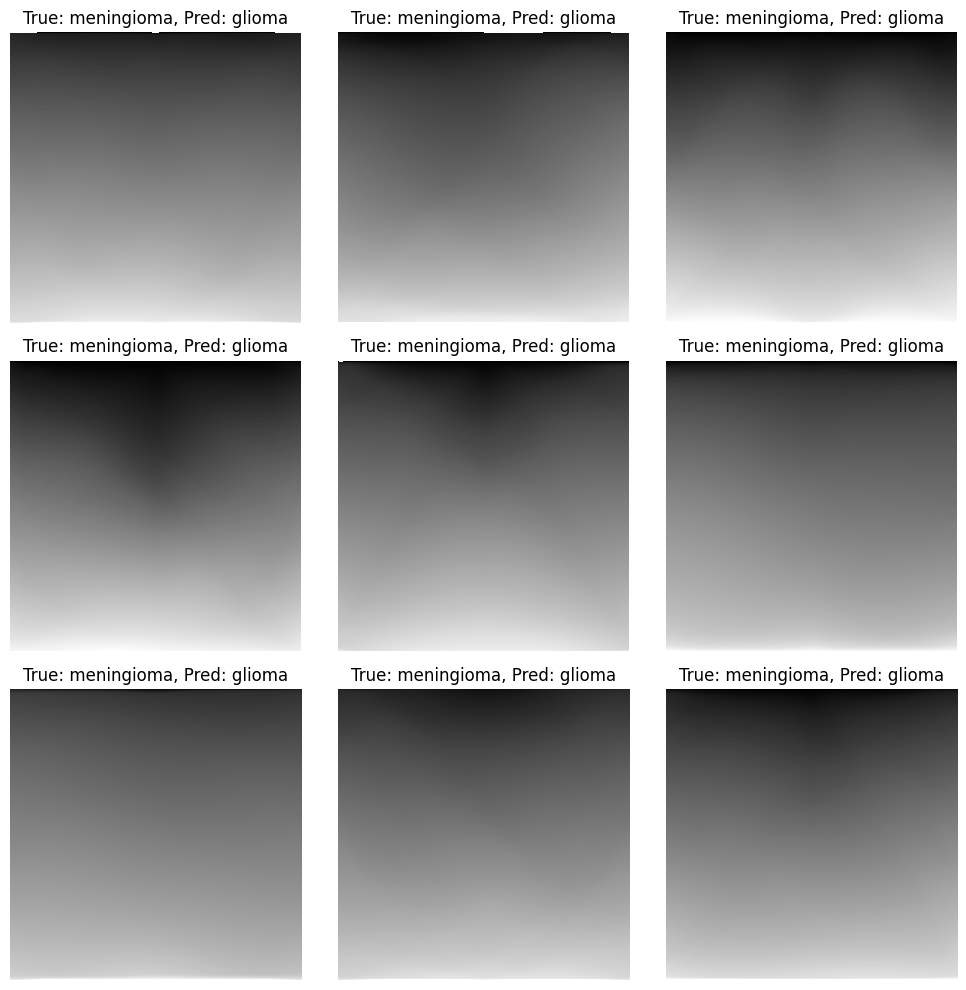

In [ ]:
import matplotlib.pyplot as plt

def show_misclassified_samples(images, true_labels, predicted_labels, indices, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices[:num_images]):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"True: {class_names[true_labels[idx]]}, Pred: {class_names[predicted_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a random sample of misclassified images
show_misclassified_samples(X_test, true_classes, predicted_classes, misclassified_indices, class_names=['glioma', 'meningioma', 'notumor', 'pituitary'])


CNN model on Brain Tumor Images

In [ ]:
from sklearn.model_selection import train_test_split
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


In [ ]:
checkpoint_path = '/content/drive/MyDrive/cnn_checkpoint.keras'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=False, verbose=1)

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

cnn_model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

In [ ]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = cnn_model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.6792 - loss: 0.8183 - val_accuracy: 0.6061 - val_loss: 1.7790
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 796ms/step - accuracy: 0.9439 - loss: 0.1972 - val_accuracy: 0.9023 - val_loss: 0.4918
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 823ms/step - accuracy: 0.9665 - loss: 0.1172 - val_accuracy: 0.6550 - val_loss: 4.3240
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 791ms/step - accuracy: 0.9732 - loss: 0.1009 - val_accuracy: 0.7893 - val_loss: 0.8618
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 791ms/step - accuracy: 0.9824 - loss: 0.0543 - val_accuracy: 0.9267 - val_loss: 0.2830
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 792ms/step - accuracy: 0.9851 - loss: 0.0580 - val_accuracy: 0.7588 - val_loss: 1.9937
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 794ms/step - accuracy: 0.9859 - loss: 0.0508 - val_accuracy: 0.9069 - val_loss: 0.3056
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 792ms/step - accuracy: 0.9811 - loss: 0.0601 

In [ ]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.8635 - loss: 0.5126
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.8459 - loss: 0.5968
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8382 - loss: 0.6696


In [ ]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
